In [1]:
!pip install torchdiffeq

In [2]:
import os
import argparse
import time
import psutil
import scipy.io
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from torchdiffeq import odeint

In [3]:
gpu = 0
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

In [95]:
train_mat = scipy.io.loadmat('../input/npdetest/S_train_20.mat')
params_train_mat = scipy.io.loadmat('../input/npdetest/params_train_20.mat')
test_mat = scipy.io.loadmat('../input/npdetest/S_test_20_extended.mat')
params_test_mat = scipy.io.loadmat('../input/npdetest/params_test_20_extended.mat')

In [96]:
train_mat = torch.tensor(train_mat['S'])
params_train_mat = torch.tensor(params_train_mat['I'])
test_mat = torch.tensor(test_mat['S'])
params_test_mat = torch.tensor(params_test_mat['I'])

In [97]:
train_mat = torch.transpose(train_mat,0, 1).unsqueeze(1)
test_mat = torch.transpose(test_mat,0, 1).unsqueeze(1)

In [98]:
train_mat.shape, test_mat.shape

(torch.Size([8000, 1, 256]), torch.Size([7600, 1, 256]))

In [8]:
params = torch.linspace(5e-3,5e-2,20).unsqueeze(1).unsqueeze(1)

In [78]:
plin = np.linspace(5e-3,5e-2,20)

In [86]:
params_test = [(plin[i]+plin[i+1])/2 for i in range(19)]

In [87]:
params_test = torch.tensor(params_test).unsqueeze(1).unsqueeze(1)

In [106]:
params_test = params_test.type(torch.DoubleTensor)

In [89]:
params_mat = torch.cat([torch.ones((400,1,1))*params[i] for i in range(20)])

In [91]:
params_mat_test = torch.cat([torch.ones((400,1,1))*params_test[i] for i in range(19)])

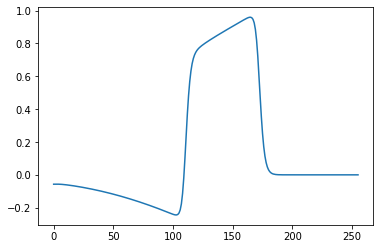

In [22]:
#for i in range(0,400,20):
plt.plot(train_mat[300,:,:].flatten())
   #print(params_train_data[i])
plt.savefig('u0.svg',bbox_inches='tight')

In [11]:
data_size = train_mat.shape[0]
print(data_size)
batch_time = 30
batch_size = 20
method = 'dopri5'
test_freq = 50
epochs = 1500
ensemble_n = 5

8000


In [12]:
def get_batch():
    batch_t = torch.arange(batch_time).float()
    start_idx = torch.arange(0,8000,400)
    s = torch.from_numpy(np.random.choice(np.arange(400-batch_time), batch_size, replace=False))
    s = start_idx + s
    batch_u0 = train_mat[s,:,:].float()
    batch_p = params.float()
    batch_u = torch.stack([train_mat[s+i,:,:] for i in range(batch_time)]).float()

    return batch_u0.to(device), batch_u.to(device), batch_t.to(device), batch_p.to(device), s

tensor([[0.0050]])


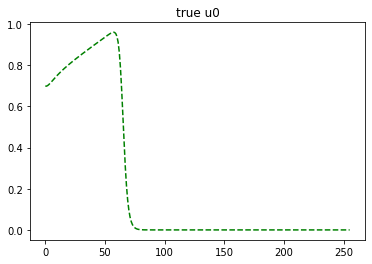

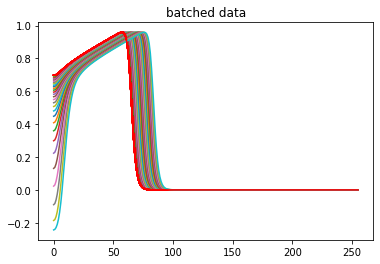

In [13]:
batch_u0, batch_u, batch_t, batch_p, s = get_batch()
batch_element = 0
i = s[batch_element]
print(batch_p[batch_element,:,:])
plt.figure()
plt.title('true u0')
plt.plot(train_mat[i,:,:].cpu().flatten(),'--g',label='true_u0')
plt.figure()
plt.title('batched data')
for j in range(batch_time):
  plt.plot(batch_u[j,batch_element,:,:].cpu().flatten())
  plt.plot(batch_u0[batch_element,:,:].cpu().flatten(),'-r',label='u0')

In [14]:
batch_u0.shape

torch.Size([20, 1, 256])

In [15]:
class ConvODEFunc(nn.Module):
    def __init__(self):
        super(ConvODEFunc, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=16, kernel_size=(1,3), stride=1, padding='same'),
            nn.Tanh(),
            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=(1,3), stride=1, padding='same')
        )
      
        self.conv[0].weight.data.normal_(0.0, 1/(16*3*2+16))
        self.conv[0].bias.data.fill_(.0)
        self.conv[2].weight.data.normal_(0.0, 1/(16*3+1))
        self.conv[2].bias.data.fill_(.0)
        
    def forward(self, t, y):
        
        o1 = self.conv(y)
        o2 = torch.zeros_like(o1)
        o = torch.cat((o1,o2),1)
        return o

In [16]:
func = ConvODEFunc().to(device)

In [17]:
ensemble = [ConvODEFunc().to(device) for i in range(ensemble_n)]

In [18]:
batch_u0, batch_u, batch_t, batch_p, s = get_batch()

In [24]:
epochs

1500

In [25]:
for jj,func in enumerate(ensemble):
    ii = 0
    lrate = 1e-3
    print('model #'+str(jj))

    optimizer = optim.Adam(func.parameters(), lr=lrate)

    loss_array = []
    itr_time = []
    start = time.time()

    for itr in range(1, epochs + 1):

        start_itr = time.time()

        batch_u0, batch_u, batch_t, batch_p, s = get_batch()
        state_param_init=torch.stack((batch_u0,batch_p*torch.ones_like(batch_u0)),1)
        pred_u = odeint(func, state_param_init, batch_t,method=method).to(device)

        loss = torch.mean(torch.pow(pred_u[:,:,0,:,:] - batch_u,2))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        itr_time.append(time.time()-start_itr)
        loss_array.append(loss.item())

        if itr % test_freq == 0:
            with torch.no_grad():
                print('Iter ' + str(itr)+'/'+str(epochs) + '\t|  Loss: ' + str(round(loss.item(),6)) + '\t|  lr: ' + str(optimizer.param_groups[0]['lr']) + '\t|  itr time: ' +str(round(itr_time[-1],5)))
                #       visualize(true_u, pred_u, func, ii, batch_u0, batch_t)
                #       ii += 1

    total_elapsed_time = time.time()-start

model #0
Iter 50/1500	|  Loss: 0.013448	|  lr: 0.001	|  itr time: 0.13319
Iter 100/1500	|  Loss: 0.010073	|  lr: 0.001	|  itr time: 0.20003
Iter 150/1500	|  Loss: 0.008191	|  lr: 0.001	|  itr time: 0.29106
Iter 200/1500	|  Loss: 0.008509	|  lr: 0.001	|  itr time: 0.3893
Iter 250/1500	|  Loss: 0.007208	|  lr: 0.001	|  itr time: 0.38913
Iter 300/1500	|  Loss: 0.008008	|  lr: 0.001	|  itr time: 0.43417
Iter 350/1500	|  Loss: 0.004737	|  lr: 0.001	|  itr time: 0.42595
Iter 400/1500	|  Loss: 0.004656	|  lr: 0.001	|  itr time: 0.47434
Iter 450/1500	|  Loss: 0.004601	|  lr: 0.001	|  itr time: 0.48498
Iter 500/1500	|  Loss: 0.00538	|  lr: 0.001	|  itr time: 0.46382
Iter 550/1500	|  Loss: 0.004683	|  lr: 0.001	|  itr time: 0.4545
Iter 600/1500	|  Loss: 0.003387	|  lr: 0.001	|  itr time: 0.44016
Iter 650/1500	|  Loss: 0.004004	|  lr: 0.001	|  itr time: 0.47641
Iter 700/1500	|  Loss: 0.00234	|  lr: 0.001	|  itr time: 0.44679
Iter 750/1500	|  Loss: 0.002745	|  lr: 0.001	|  itr time: 0.48222
Iter 8

In [ ]:
func

In [26]:
batch_u0, batch_u, batch_t, batch_p, s = get_batch()
y0=torch.stack((batch_u0,batch_p*torch.ones_like(batch_u0)),1)
pred_u = odeint(func, y0, batch_t,method=method).to(device)   

<Figure size 432x288 with 0 Axes>

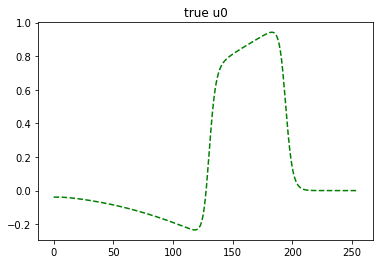

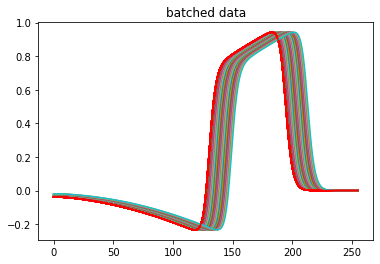

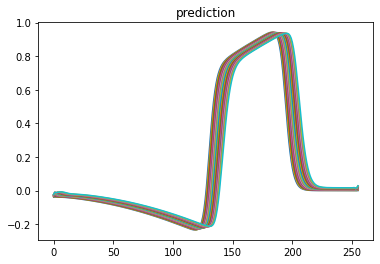

In [27]:
plt.figure().patch.set_facecolor('#FFFFFF')

batch_element = 1
i = s[batch_element]
plt.figure()
plt.title('true u0')
plt.plot(train_mat[i,:,:].flatten(),'--g',label='true_u0')
plt.figure()
plt.title('batched data')
for j in range(batch_time):
  plt.plot(batch_u[j,batch_element,:,:].cpu().flatten())
  plt.plot(batch_u0[batch_element,:,:].cpu().flatten(),'-r',label='u0')
plt.savefig('target.png',dpi=200)

plt.figure()
plt.title('prediction')
for j in range(20):
  plt.plot(pred_u[j,batch_element,0,:,:].cpu().detach().flatten())

plt.savefig('pred.png',dpi=200)
#print(params_train_data[i])

In [36]:
t0 = 300
pred_t = torch.arange(400-t0).float().to(device)   
pred_u0 = train_mat[t0,:,:].unsqueeze(0).float().to(device)   
mu = params_mat[t0].to(device)*torch.ones_like(pred_u0)
u0 = torch.stack((pred_u0,mu),1)
pred_u = odeint(func, u0, pred_t,method=method).to(device)   

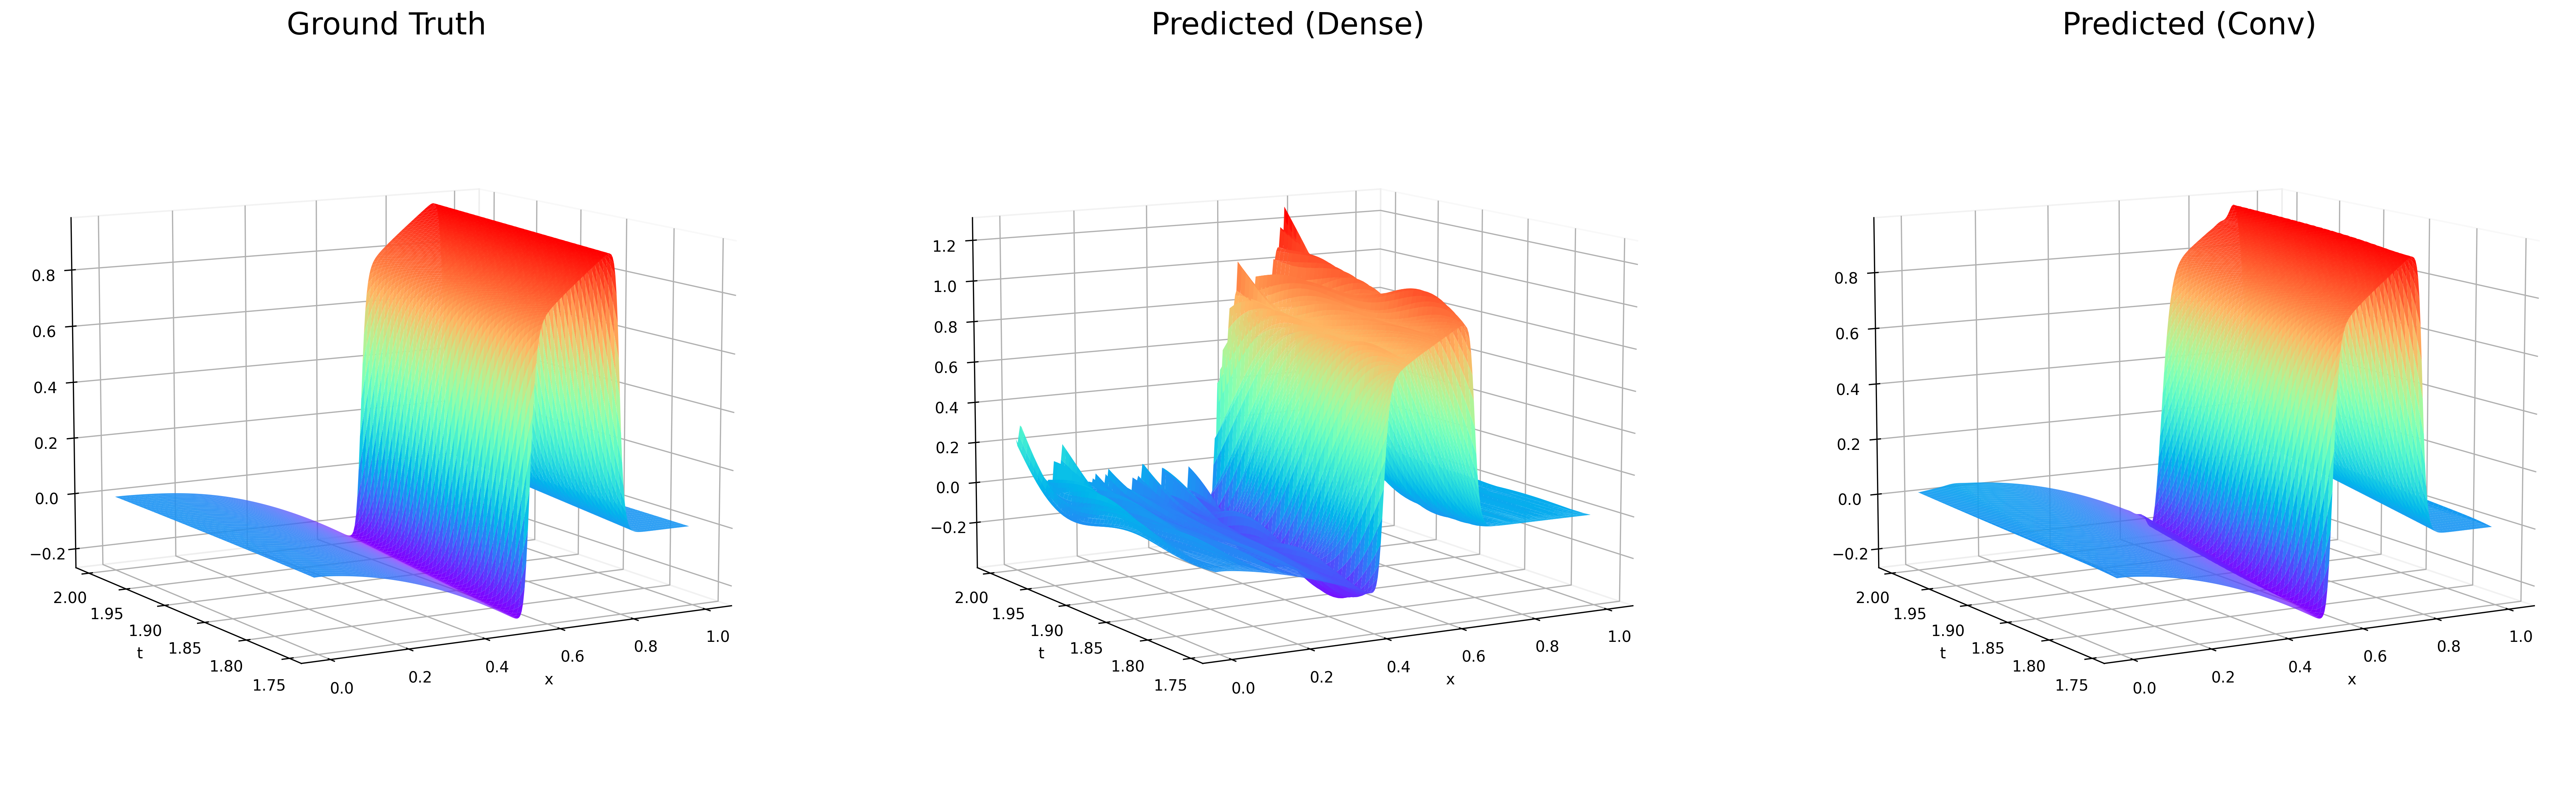

In [54]:
t = np.linspace(0, 2, 400)[t0:]
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z_2 = train_mat[t0:400,:].squeeze(1).numpy()
fig = plt.figure(figsize=(30,12),dpi=300)
ax = fig.add_subplot(131,projection='3d')
ax.plot_surface(X, Y, Z_2, cmap=plt.cm.rainbow,linewidth=0, antialiased=True,rcount=1000, ccount=1000)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_title('Ground Truth',fontsize=20)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.view_init(10, 240)

t = np.linspace(0, 2, 400)[t0:]
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z_dense = np.loadtxt('../input/zpred350/z.txt')
ax = fig.add_subplot(132,projection='3d')
ax.plot_surface(X, Y, Z_dense, cmap=plt.cm.rainbow,linewidth=0, antialiased=True,rcount=1000, ccount=1000)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_title('Predicted (Dense)',fontsize=20)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.view_init(10, 240)

X, Y = np.meshgrid(x, t)
Z_1 = pred_u[:,0,0,0,:].detach().cpu().numpy()
ax = fig.add_subplot(133,projection='3d')
ax.plot_surface(X, Y, Z_1, cmap=plt.cm.rainbow,linewidth=0, antialiased=True,rcount=1000, ccount=1000)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_xlabel('x')
ax.set_ylabel('t')

ax.set_title('Predicted (Conv)',fontsize=20)
ax.view_init(10, 240)
plt.savefig('denseconv.png',dpi=300,bbox_inches='tight',transparent=False)

In [69]:
z350

array([[-5.70348799e-02, -5.69090247e-02, -5.67522794e-02, ...,
         1.07769471e-16,  8.22376083e-17,  7.42933194e-17],
       [-5.95770814e-02, -5.99514432e-02, -6.05669208e-02, ...,
         8.09795398e-04,  2.78008636e-04, -1.69955636e-03],
       [-6.15020432e-02, -6.24341294e-02, -6.36718050e-02, ...,
         1.72892504e-03,  4.38331946e-04, -3.35817435e-03],
       ...,
       [ 1.62598684e-01,  1.29546165e-01,  1.74439624e-01, ...,
         5.63523993e-02, -8.94560199e-03, -8.47233832e-02],
       [ 1.94529831e-01,  1.60962552e-01,  2.10655287e-01, ...,
         6.31771460e-02, -1.10155968e-02, -9.29611847e-02],
       [ 2.27370366e-01,  1.93258509e-01,  2.47936696e-01, ...,
         6.99673072e-02, -1.32065061e-02, -1.01318665e-01]])

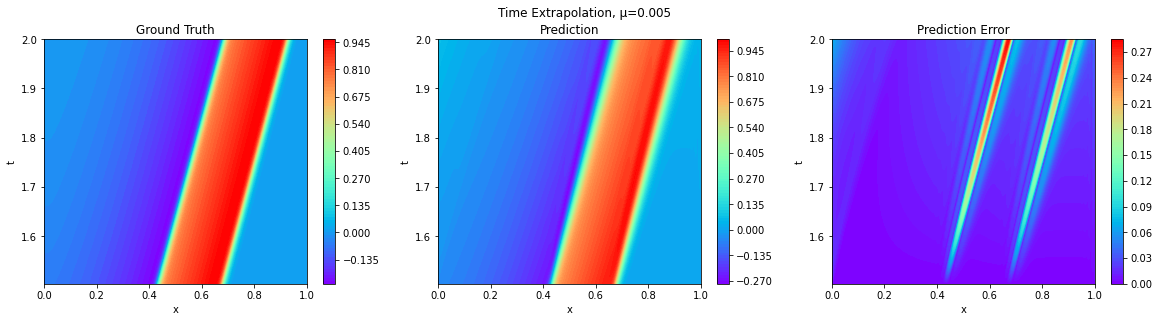

In [70]:
func = ensemble[2]

t0 = 300
batch = 0
batch_shift = 400*batch
pred_t = torch.arange(400-t0).float().to(device)   
pred_u0 = train_mat[batch_shift+t0,:,:].unsqueeze(0).float().to(device)   
mu = params_mat[batch_shift+t0].to(device)*torch.ones_like(pred_u0)
u0 = torch.stack((pred_u0,mu),1)
pred_u = odeint(func, u0, pred_t,method=method).to(device)   

t = np.linspace(0, 2, 400)[t0:]
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z_2 = train_mat[batch_shift+t0:batch_shift+400,:].squeeze(1).numpy()
fig = plt.figure(figsize=(20,4.5))
ax1 = fig.add_subplot(131)
plt1 = ax1.contourf(X, Y, Z_2,100,cmap=plt.cm.rainbow)
ax1.set_title('Ground Truth')
ax1.set_xlabel('x')
ax1.set_ylabel('t')

ax2 = fig.add_subplot(132)
Z_1 = pred_u[:,0,0,0,:].detach().cpu().numpy()
plt2 = ax2.contourf(X, Y, Z_1,100,cmap=plt.cm.rainbow)
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_title('Prediction')

ax3 = fig.add_subplot(133)
ax3.set_title('Prediction Error')
plt3 = ax3.contourf(X, Y, np.abs(Z_2-Z_1),100,cmap=plt.cm.rainbow)
ax3.set_xlabel('x')
ax3.set_ylabel('t')

fig.colorbar(plt1, ax=ax1)
fig.colorbar(plt2, ax=ax2)
fig.colorbar(plt3, ax=ax3)
plt.suptitle('Time Extrapolation, μ='+str(mu[0,0,0].cpu().numpy()))
plt.savefig('pde1.png',dpi=300,bbox_inches='tight',transparent=False)

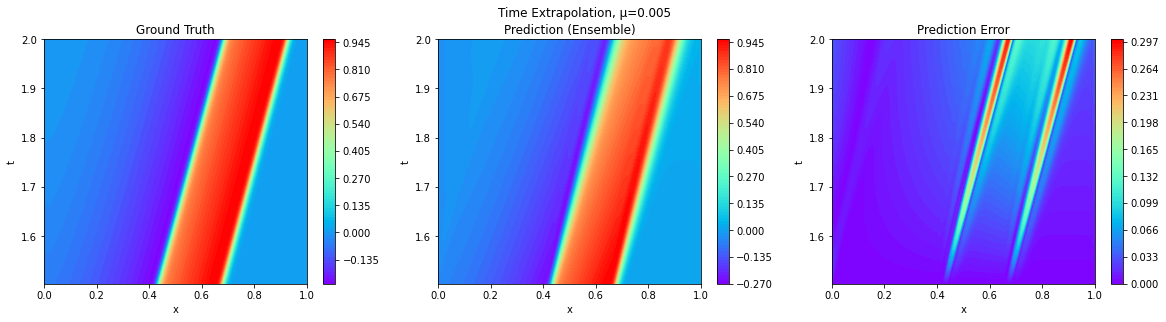

In [67]:
t0 = 300
batch = 0
batch_shift = 400*batch
pred_t = torch.arange(400-t0).float().to(device)   
pred_u0 = train_mat[batch_shift+t0,:,:].unsqueeze(0).float().to(device)   
mu = params_mat[batch_shift+t0].to(device)*torch.ones_like(pred_u0)
u0 = torch.stack((pred_u0,mu),1)
pred_u = odeint(func, u0, pred_t,method=method).to(device)   

t = np.linspace(0, 2, 400)[t0:]
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z_2 = train_mat[batch_shift+t0:batch_shift+400,:].squeeze(1).numpy()
fig = plt.figure(figsize=(20,4.5))
ax1 = fig.add_subplot(131)
plt1 = ax1.contourf(X, Y, Z_2,100,cmap=plt.cm.rainbow)
ax1.set_title('Ground Truth')
ax1.set_xlabel('x')
ax1.set_ylabel('t')

ax2 = fig.add_subplot(132)
Z_ens = np.zeros_like(Z_2)
for f in ensemble:
    pred_u = odeint(f, u0, pred_t,method=method).to(device)   
    Z_ens += pred_u[:,0,0,0,:].detach().cpu().numpy()   
Z_ens /= 5
plt2 = ax2.contourf(X, Y, Z_ens,100,cmap=plt.cm.rainbow)
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_title('Prediction (Ensemble)')

ax3 = fig.add_subplot(133)
ax3.set_title('Prediction Error')
plt3 = ax3.contourf(X, Y, np.abs(Z_2-Z_ens),100,cmap=plt.cm.rainbow)
ax3.set_xlabel('x')
ax3.set_ylabel('t')

fig.colorbar(plt1, ax=ax1)
fig.colorbar(plt2, ax=ax2)
fig.colorbar(plt3, ax=ax3)
plt.suptitle('Time Extrapolation, μ='+str(mu[0,0,0].cpu().numpy()))
plt.savefig('pde1.png',dpi=300,bbox_inches='tight',transparent=False)

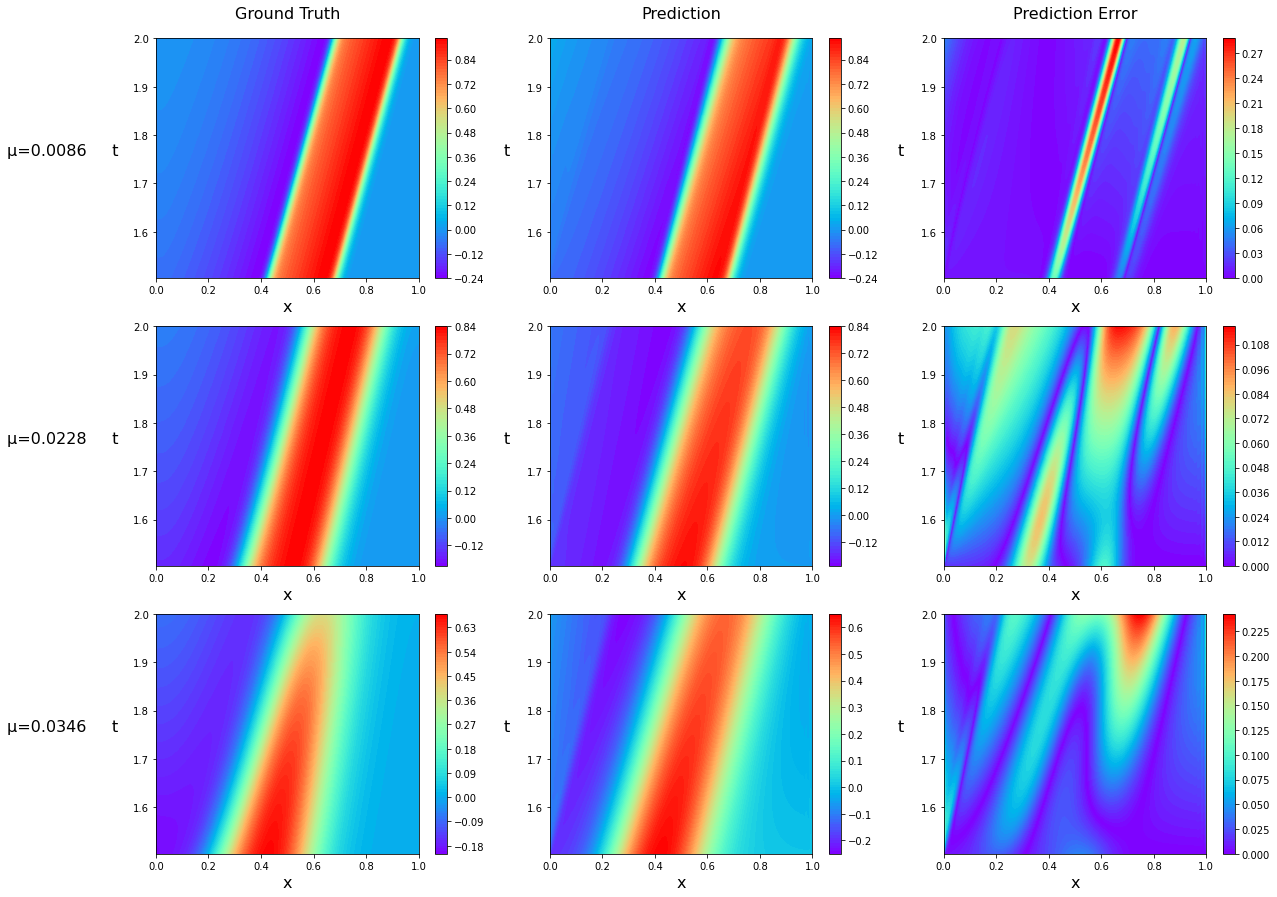

In [111]:
fig = plt.figure(figsize=(20,15))

fs=16
t0 = 300
batch = 1
batch_shift = 400*batch
pred_t = torch.arange(400-t0).float().to(device)   
pred_u0 = test_mat[batch_shift+t0,:,:].unsqueeze(0).float().to(device)   
mu = params_mat_test[batch_shift+t0].to(device)*torch.ones_like(pred_u0)
u0 = torch.stack((pred_u0,mu.float()),1)
pred_u = odeint(func, u0, pred_t,method=method).to(device)   

t = np.linspace(0, 2, 400)[t0:]
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z_2 = train_mat[batch_shift+t0:batch_shift+400,:].squeeze(1).numpy()

ax1 = fig.add_subplot(331)
plt1 = ax1.contourf(X, Y, Z_2,100,cmap=plt.cm.rainbow)
ax1.set_title('Ground Truth',pad=20,fontsize=fs)
ax1.set_xlabel('x',fontsize=fs)
ax1.set_ylabel( 'μ='+str(round(mu[0,0,0].cpu().numpy().max(),4))+'     t', rotation=0, fontsize=fs,labelpad=70)

ax2 = fig.add_subplot(332)
Z_1 = pred_u[:,0,0,0,:].detach().cpu().numpy()
plt2 = ax2.contourf(X, Y, Z_1,100,cmap=plt.cm.rainbow)
ax2.set_xlabel('x',fontsize=fs)
ax2.set_ylabel('t',fontsize=fs, rotation=0,labelpad=20)
ax2.set_title('Prediction',pad=20,fontsize=fs)

ax3 = fig.add_subplot(333)
ax3.set_title('Prediction Error',pad=20,fontsize=fs)
plt3 = ax3.contourf(X, Y, np.abs(Z_2-Z_1),100,cmap=plt.cm.rainbow)
ax3.set_xlabel('x',fontsize=fs)
ax3.set_ylabel('t',fontsize=fs, rotation=0,labelpad=20)

fig.colorbar(plt1, ax=ax1)
fig.colorbar(plt2, ax=ax2)
fig.colorbar(plt3, ax=ax3)


t0 = 300
batch = 7
batch_shift = 400*batch
pred_t = torch.arange(400-t0).float().to(device)   
pred_u0 = test_mat[batch_shift+t0,:,:].unsqueeze(0).float().to(device)   
mu = params_mat_test[batch_shift+t0].to(device)*torch.ones_like(pred_u0)
u0 = torch.stack((pred_u0,mu.float()),1)
pred_u = odeint(func, u0, pred_t,method=method).to(device)   

t = np.linspace(0, 2, 400)[t0:]
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z_2 = train_mat[batch_shift+t0:batch_shift+400,:].squeeze(1).numpy()

ax1 = fig.add_subplot(334)
plt1 = ax1.contourf(X, Y, Z_2,100,cmap=plt.cm.rainbow)
ax1.set_xlabel('x',fontsize=fs)
ax1.set_ylabel( 'μ='+str(round(mu[0,0,0].cpu().numpy().max(),4))+'     t', rotation=0, fontsize=fs,labelpad=70)

ax2 = fig.add_subplot(335)
Z_1 = pred_u[:,0,0,0,:].detach().cpu().numpy()
plt2 = ax2.contourf(X, Y, Z_1,100,cmap=plt.cm.rainbow)
ax2.set_xlabel('x',fontsize=fs)
ax2.set_ylabel('t',fontsize=fs, rotation=0,labelpad=20)

ax3 = fig.add_subplot(336)
plt3 = ax3.contourf(X, Y, np.abs(Z_2-Z_1),100,cmap=plt.cm.rainbow)
ax3.set_xlabel('x',fontsize=fs)
ax3.set_ylabel('t',fontsize=fs, rotation=0,labelpad=20)

fig.colorbar(plt1, ax=ax1)
fig.colorbar(plt2, ax=ax2)
fig.colorbar(plt3, ax=ax3)

t0 = 300
batch = 12

batch_shift = 400*batch
pred_t = torch.arange(400-t0).float().to(device)   
pred_u0 = test_mat[batch_shift+t0,:,:].unsqueeze(0).float().to(device)   
mu = params_mat_test[batch_shift+t0].to(device)*torch.ones_like(pred_u0)
u0 = torch.stack((pred_u0,mu.float()),1)
pred_u = odeint(func, u0, pred_t,method=method).to(device)   

t = np.linspace(0, 2, 400)[t0:]
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z_2 = train_mat[batch_shift+t0:batch_shift+400,:].squeeze(1).numpy()

ax1 = fig.add_subplot(337)
plt1 = ax1.contourf(X, Y, Z_2,100,cmap=plt.cm.rainbow)
ax1.set_xlabel('x',fontsize=fs)
ax1.set_ylabel( 'μ='+str(round(mu[0,0,0].cpu().numpy().max(),4))+'     t', rotation=0, fontsize=fs,labelpad=70)

ax2 = fig.add_subplot(338)
Z_1 = pred_u[:,0,0,0,:].detach().cpu().numpy()
plt2 = ax2.contourf(X, Y, Z_1,100,cmap=plt.cm.rainbow)
ax2.set_xlabel('x',fontsize=fs)
ax2.set_ylabel('t',fontsize=fs, rotation=0,labelpad=20)

ax3 = fig.add_subplot(339)
plt3 = ax3.contourf(X, Y, np.abs(Z_2-Z_1),100,cmap=plt.cm.rainbow)
ax3.set_xlabel('x',fontsize=fs)
ax3.set_ylabel('t',fontsize=fs, rotation=0,labelpad=20)

fig.colorbar(plt1, ax=ax1)
fig.colorbar(plt2, ax=ax2)
fig.colorbar(plt3, ax=ax3)
plt.savefig('pde2.png',dpi=300,bbox_inches='tight',transparent=False)

In [ ]:
t = np.linspace(0, 2, 400)[t0:]
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
fig = plt.figure(figsize=(20,4.5))
ax1 = fig.add_subplot(131)
plt1 = ax1.contourf(X, Y, Z_2,100,cmap=plt.cm.rainbow)
ax1.set_title('Ground Truth')
ax1.set_xlabel('x')
ax1.set_ylabel('t')

ax2 = fig.add_subplot(132)
plt2 = ax2.contourf(X, Y, Z_1,100,cmap=plt.cm.rainbow)
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_title('Prediction')

ax3 = fig.add_subplot(133)
ax3.set_title('Prediction Error')
plt3 = ax3.contourf(X, Y, np.abs(Z_2-Z_1),100,cmap=plt.cm.rainbow)
ax3.set_xlabel('x')
ax3.set_ylabel('t')

fig.colorbar(plt1, ax=ax1)
fig.colorbar(plt2, ax=ax2)
fig.colorbar(plt3, ax=ax3)
plt.suptitle('Time Extrapolation, μ=0.5')
plt.savefig('pde1.png',dpi=300,bbox_inches='tight',transparent=False)

In [ ]:
t = np.linspace(0, 2, 400)[t0:]
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z_2 = train_mat[t0:400,:].squeeze(1).numpy()
fig = plt.figure(figsize=(10,7))
plt.contourf(X, Y, Z_2,100,cmap=plt.cm.rainbow)
plt.colorbar()
plt.title

In [ ]:
t = np.linspace(0, 2, 400)[t0:]
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z_2 = train_mat[t0:400,:].squeeze(1).numpy()
fig = plt.figure(figsize=(10,7))
plt.contourf(X, Y, Z_1-Z_2,100,cmap=plt.cm.rainbow)
plt.colorbar()
plt.title

In [ ]:
t0 = 300
angle1 = 15
angle2 = 250

t = np.linspace(0, 2, 400)[t0:]
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z = train_mat[t0:400,:].squeeze(1).numpy()
fig = plt.figure(figsize=(20,10),facecolor='white')

ax = fig.add_subplot(121, projection='3d')

ax.plot_surface(X, Y, Z, cmap=plt.cm.rainbow,linewidth=0, antialiased=True,rcount=1000, ccount=1000)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_title('True',fontsize=16)
ax.view_init(10, 240)

t = np.linspace(0, 2, 400)[t0:]
x = np.linspace(0, 1, 256)
pred_t = torch.arange(400-t0).float().to(device)   
pred_u0 = train_mat[t0,:,:].unsqueeze(0).float().to(device)   
mu = params_mat[t0].to(device)*torch.ones_like(pred_u0)
u0 = torch.stack((pred_u0,mu),1)
pred_u = odeint(func, u0, pred_t,method=method).to(device)   
Z = pred_u[:,0,0,0,:].detach().cpu().numpy()

ax = fig.add_subplot(122, projection='3d')

ax.plot_surface(X, Y, Z, cmap=plt.cm.rainbow,linewidth=0, antialiased=True,rcount=1000, ccount=1000)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_title('Predicted',fontsize=16)
ax.view_init(10, 240)

plt.savefig('double.png',dpi=200,bbox_inches='tight',transparent=False)

In [ ]:
t0 = 300
angle1 = 15
angle2 = 250

t = np.linspace(0, 2, 400)[t0:]
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z_3 = train_mat[t0:400,:].squeeze(1).numpy()
fig = plt.figure(figsize=(20,10),facecolor='white')

ax1 = fig.add_subplot(121, projection='3d')

ax1.plot_surface(X, Y, Z_3, cmap=plt.cm.rainbow,linewidth=0, antialiased=True,rcount=1000, ccount=1000)
ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False
ax1.set_title('True',fontsize=16)
ax1.view_init(10, 240)



ax2 = fig.add_subplot(122, projection='3d')

t = np.linspace(0, 2, 400)[t0:]
x = np.linspace(0, 1, 256)
pred_t = torch.arange(400-t0).float().to(device)   
pred_u0 = train_mat[t0,:,:].unsqueeze(0).float().to(device)   
mu = params_mat[t0].to(device)*torch.ones_like(pred_u0)
u0 = torch.stack((pred_u0,mu),1)
Z_4 = np.zeros_like(Z_3)
for func in ensemble:
    pred_u = odeint(func, u0, pred_t,method=method).to(device)   
    Z_4 += pred_u[:,0,0,0,:].detach().cpu().numpy()

ax2.plot_surface(X, Y, Z_4/5, cmap=plt.cm.rainbow,linewidth=0, antialiased=True,rcount=1000, ccount=1000)
ax2.xaxis.pane.fill = False
ax2.yaxis.pane.fill = False
ax2.zaxis.pane.fill = False
ax2.set_title('Predicted',fontsize=16)
ax2.view_init(10, 240)

plt.savefig('double.png',dpi=200,bbox_inches='tight',transparent=False)

In [ ]:
pred_u.shape

In [ ]:
train_mat[t0:400,:].squeeze(1).shape

In [ ]:
mse = torch.mean(torch.pow(train_mat[t0:400,:].squeeze(1)-Z,2))
mse

In [ ]:
batch_u0, batch_u, batch_t, s = get_batch()
batch_u0.shape, batch_u.shape, batch_t.shape
pred_u = odeint(func, batch_u0, batch_t,method=method).to(device)   

plt.figure().patch.set_facecolor('#FFFFFF')

batch_element = 2
i = s[batch_element]
plt.figure()
plt.title('true u0')
plt.plot(train_data[i,:,:].flatten(),'--g',label='true_u0')
plt.figure()
plt.title('batched data')
for j in range(batch_time):
  plt.plot(batch_u[j,batch_element,:,:].cpu().flatten())
  plt.plot(batch_u0[batch_element,:,:].cpu().flatten(),'-r',label='u0')
plt.savefig('target.png',dpi=200)

plt.figure()
plt.title('prediction')
for j in range(batch_time):
  plt.plot(pred_u[j,batch_element,:,:].cpu().detach().flatten())

plt.savefig('pred.png',dpi=200)
#print(params_train_data[i])

In [31]:
def save_ensemble(ensemble):
    for i,model in enumerate(ensemble):
        torch.save(model,'ef'+str(i)+'.pt')

In [32]:
save_ensemble(ensemble)